# Contextualizing Results

Welcome to the Jupyter notebook that complements the IPN Summer School > Advanced Analytics for Neuroscience > Contextualizing Results (July 2nd, 2021) lecture.

This notebook will cover:
- fetching microarray gene expression data from the [Allen Human Brain Atlas](https://human.brain-map.org/) using the open-source python toolbox, `abagen`
- fetching [Neurosynth](https://neurosynth.org/) functional activation maps
- using spatial null models when comparing brain maps

## `abagen` processing

The complete Read The Docs for `abagen` can be found [here](https://abagen.readthedocs.io/en/stable/index.html). 

In [ ]:
# If using Google Colab, install the dependencies
!pip install --upgrade numpy scipy matplotlib pandas
!pip install git+https://github.com/netneurolab/netneurotools
!pip install git+https://github.com/neurosynth/neurosynth
!pip install abagen

In [2]:
import abagen
from nilearn.datasets import fetch_atlas_schaefer_2018
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr

'1.2.5'

In [3]:
# mount google drive to get files on drive
# put schaefer200coords.npy in /content/drive/My Drive
# if running locally, skip this
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


All `abagen` needs is a `.nii.gz` atlas in which the gene expression data will be parcellated.
Here, we will be parcellating the gene expression data into 200 cortical nodes, according to the Schaefer et al., 2018 parcellation.
Note that spatial coverage in the left hemisphere is more complete than in the right hemisphere.
For this reason, we will conduct our analyses in the left hemisphere only.
(It is definitely possible to use whole-brain gene expression data, and there are several options for what to do with the missing data.
You can read more about that in the `abagen` documentation.
The preprint will be out soon!)

In [4]:
# get schaefer atlas
schaefer = fetch_atlas_schaefer_2018(n_rois=200)
# if running locally: coord = np.load('path/to/schaefer200coords.npy')
coords = np.load('/content/drive/My Drive/schaefer200coords.npy')
nnodes = len(coords)

# get node x gene data for all 6 donors
# return_donors=False for full concatenated node x gene matrix
expression = abagen.get_expression_data(schaefer['maps'], return_donors=True)

# get differential stability of each gene
expression, ds = abagen.correct.keep_stable_genes(list(expression.values()),
                                                  threshold=0.1,
                                                  percentile=False,
                                                  return_stability=True)
# make single node x gene expression matrix
expression = pd.concat(expression).groupby('label').mean()


Dataset created in /root/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Gene coexpression is the correlation of gene expression across genes between pairs of brain regions.
It is not independent of distance!
(More on that later.)

Text(0, 0.5, 'Gene coexpression')

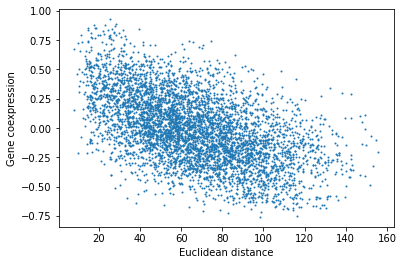

In [5]:
# gene coexpression matrix of left hemisphere only
gc = np.corrcoef(zscore(expression.iloc[:100]))

# distance matrix of left hemisphere only
distance = squareform(pdist(coords[:100, :], metric='euclidean'))

mask = np.triu(np.ones(int(nnodes/2)), 1) > 0

fig, ax = plt.subplots()
ax.scatter(distance[mask], gc[mask], s=1)
ax.set_xlabel('Euclidean distance')
ax.set_ylabel('Gene coexpression')

## Neurosynth

We'll be using code from [https://github.com/neurosynth/neurosynth](https://github.com/neurosynth/neurosynth) to run the meta-analysis on a set of 123 cognitive/behavioural terms from the [Cognitive Atlas](https://www.cognitiveatlas.org/concepts/a/).
We'll be pulling the most up-to-date version of `neurosynth` (instead of the version on `pip`) so that we don't need to downgrade our `pandas`.
This will require a `pip install git+https://github.com/neurosynth/neurosynth`.

Note that much of the code comes from [here](https://github.com/netneurolab/markello_spatialnulls/blob/master/scripts/empirical/fetch_neurosynth_maps.py).

I've uploaded this bit as a script [here](), so you don't have to code along.
You can just run the script and get your data and you should be good to go.

In [10]:
import contextlib
import json
import os
from pathlib import Path

import requests
from nilearn.input_data import NiftiLabelsMasker
from nilearn._utils import check_niimg

import neurosynth as ns

Some set up:

In [11]:
# this is where the raw and parcellated data will be stored
NSDIR = Path('./data/raw/neurosynth').resolve()
PARDIR = Path('./data/derivatives/neurosynth').resolve()

# these are the images from the neurosynth analyses we'll save
# can add 'uniformity-test_z' plus more, if desired
IMAGES = ['association-test_z']

Let's make some functions:

First, we need something to grab the NeuroSynth database and features.

In [12]:
def fetch_ns_data(directory):
    """ Fetches NeuroSynth database + features to `directory`
    Paramerters
    -----------
    directory : str or os.PathLike
        Path to directory where data should be saved
    Returns
    -------
    database, features : PathLike
        Paths to downloaded NS data
    """

    directory = Path(directory)

    # if not already downloaded, download the NS data and unpack it
    database, features = directory / 'database.txt', directory / 'features.txt'
    if not database.exists() or not features.exists():
        with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
            ns.dataset.download(path=directory, unpack=True)
        try:  # remove tarball if it wasn't removed for some reason
            (directory / 'current_data.tar.gz').unlink()
        except FileNotFoundError:
            pass

    return database, features

Since we're only using terms from the Cognitive Atlas, let's make something to grab those terms.
I feel like I should emphasize again that Ross wrote all this code and I'm just stealing his stuff.

In [13]:
def get_cogatlas_concepts(url=None):
    """ Fetches list of concepts from the Cognitive Atlas
    Parameters
    ----------
    url : str
        URL to Cognitive Atlas API
    Returns
    -------
    concepts : set
        Unordered set of terms
    """

    if url is None:
        url = 'https://cognitiveatlas.org/api/v-alpha/concept'

    req = requests.get(url)
    req.raise_for_status()
    concepts = set([f.get('name') for f in json.loads(req.content)])

    return concepts

Now a function that does the bulk of the work.
It uses the `MetaAnalysis` function from `neurosynth` to make association maps for the features we defined above (Cognitive Atlas terms).

In [14]:
def run_meta_analyses(database, features, use_features=None, outdir=None):
    """
    Runs NS-style meta-analysis based on `database` and `features`
    Parameters
    ----------
    database, features : str or os.PathLike
        Path to NS-style database.txt and features.txt files
    use_features : list, optional
        List of features on which to run NS meta-analyses; if not supplied all
        terms in `features` will be used
    outdir : str or os.PathLike
        Path to output directory where derived files should be saved
    Returns
    -------
    generated : list of str
        List of filepaths to generated term meta-analysis directories
    """

    # check outdir
    if outdir is None:
        outdir = NSDIR
    outdir = Path(outdir)

    # make database and load feature names; annoyingly slow
    dataset = ns.Dataset(str(database))
    dataset.add_features(str(features))
    features = set(dataset.get_feature_names())

    # if we only want a subset of the features take the set intersection
    if use_features is not None:
        features = set(features) & set(use_features)
    pad = max([len(f) for f in features])

    generated = []
    for word in sorted(features):
        msg = f'Running meta-analysis for term: {word:<{pad}}'
        print(msg, end='\r', flush=True)

        # run meta-analysis + save specified outputs (only if they don't exist)
        path = outdir / word.replace(' ', '_')
        path.mkdir(exist_ok=True)
        if not all((path / f'{f}.nii.gz').exists() for f in IMAGES):
            ma = ns.MetaAnalysis(dataset, dataset.get_studies(features=word))
            ma.save_results(path, image_list=IMAGES)

        # store MA path
        generated.append(path)

    print(' ' * len(msg) + '\b' * len(msg), end='', flush=True)

    return generated

And finally, a function to parcellate our data into the 200-node Schaefer parcellation we've been using so far.

In [15]:
def parcellate_meta(outputs, annots, fname, regions):
    # empty dataframe to hold our parcellated data
    data = pd.DataFrame(index=regions)
    mask = NiftiLabelsMasker(annots, resampling_target='data')

    for outdir in outputs:
        cdata = []
        mgh = outdir / 'association-test_z.nii.gz'

        cdata.append(mask.fit_transform(
            check_niimg(mgh.__str__(), atleast_4d=True)).squeeze())

        # aaaand store it in the dataframe
        data = data.assign(**{outdir.name: np.hstack(cdata)})

    # now we save the dataframe! wooo data!
    data.to_csv(fname, sep=',')
    return fname

Now we're ready to actually run everything and get our data (and we will ignore the `RuntimeWarning`.)

In [16]:
NSDIR.mkdir(parents=True, exist_ok=True)
PARDIR.mkdir(parents=True, exist_ok=True)

# get concepts from CogAtlas and run relevant NS meta-analyses,
database, features = fetch_ns_data(NSDIR)
generated = run_meta_analyses(database, features, get_cogatlas_concepts(),
                              outdir=NSDIR)

# get parcellations that we'll use to parcellate data
schaefer = fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)
labels = []
for i in range(len(schaefer['labels'])):
    labels.append(schaefer['labels'][i].decode("utf-8"))

# parcellate data and save to directory
parcellate_meta(generated, schaefer['maps'],
                PARDIR / 'atl-schaefer2018_res-200_neurosynth.csv',
                regions=labels)

/usr/local/lib/python3.7/dist-packages/neurosynth/analysis/meta.py:136: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/usr/local/lib/python3.7/dist-packages/neurosynth/analysis/meta.py:141: RuntimeWarning: invalid value encountered in true_divide
  pFgA_prior = pAgF * prior / pA_prior


                                                       Downloading data from https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz ...


 ...done. (0 seconds, 0 min)


PosixPath('/content/data/derivatives/neurosynth/atl-schaefer2018_res-200_neurosynth.csv')

## Spatial nulls

The brain is spatially embedded, which means brain regions are not independent of one another.
Many statistical tests assume independence between observations, but the brain violates this assumption.
For this reason, we need to use statistical tests and null models that account for this spatial embedding.
One method is the [spin test](https://www.sciencedirect.com/science/article/pii/S1053811918304968), which projects the brain to a sphere, randomly rotates the sphere $n$ times, and then projects the sphere back onto the brain.
This results in a jumbled brain map with preserved spatial embedding.
We will be applying one variation of the spin test to Pearson's correlations between the gene expression and functional association maps we worked with above.

In [6]:
from netneurotools import stats
import random

The `netneurotools` [repo](https://github.com/netneurolab/netneurotools) includes many handy tools, including code to generate spatial-autocorrelation preserving permutations of brain regions.
The function `gen_spinsamples` can generate many different types of spin samples. 
You can read more about the different types of spatial nulls at [Markello & Misic 2021](https://www.sciencedirect.com/science/article/pii/S1053811921003293).

In [7]:
# hemisphere labels
hemi = np.zeros((len(coords),))
hemi[100:] = 1

# get 1000 spin samples
spins = stats.gen_spinsamples(coords, hemi)

Here's a function for computing Pearson's $r$ correlation coefficients and spin-derived $p$-values.

In [8]:
# write spin test function
def corr_spin(x, y, spins, nspins):
    rho, _ = pearsonr(x, y)
    null = np.zeros((nspins,))
    for i in range(nspins):
        null[i], _ = pearsonr(x, y[spins[:, i]])

    pval = (1 + sum(abs((null - np.mean(null))) >
                    abs((rho - np.mean(null))))) / (nspins + 1)
    return rho, pval

Now: which genes are correlated with the functional association of fear?

In [10]:
# load parcellated neurosynth maps
# PARDIR = Path('./data/derivatives/neurosynth').resolve()
# neurosynth = pd.read_csv(PARDIR / 'atl-schaefer2018_res-200_neurosynth.csv')
# or,
neurosynth = pd.read_csv('/content/drive/My Drive/atl-schaefer2018_res-200_neurosynth.csv')

# grab the fear map
fear = neurosynth['fear']

# correlate each gene to fear - left hemisphere only!
rho = np.zeros((expression.shape[1],))
pval = np.zeros((expression.shape[1],))
for i in range(expression.shape[1]):
    rho[i], pval[i] = pearsonr(fear.array[:100], expression.iloc[:100,i].array)
# get the most correlated gene
max_idx = np.argmax(rho)
max_gene = expression.columns[max_idx]
print('corr(fear, ' + max_gene + ') is ' 
      + str(rho[max_idx]) +'. The p-value without accounting for spatial autocorrelation is '
      + str(pval[max_idx]) +'.')

corr(fear, GNG10) is 0.6815884689574915. The p-value without accounting for spatial autocorrelation is 5.936657416821497e-15.


Since running spin-nulls takes time, we'll just do it for two genes.

In [11]:
# get p_spin of correlation between fear and GNG10 (maximally correlated gene)
_, pspin_gng = corr_spin(fear.array[:100], expression[max_gene].array[:100], spins[:100,:], 1000)
# for comparison, grab a random gene
rand = random.randint(0, expression.shape[1]-1)
_, pspin_rand = corr_spin(fear.array[:100], expression.iloc[:100, rand].array, spins[:100, :], 1000)

print('The spin-test p-value of the correlation between fear association and '
      + expression.columns[max_idx] + ' is ' + str(pspin_gng) +'.')
print('corr(fear, ' + expression.columns[rand] + ') is '
      + str(rho[rand]) + '. The p-value without accounting for spatial autocorrelation is '
      + str(pval[rand]) + '. The p-value when accounting for spatial autocorrelation is '
      + str(pspin_rand) + '.')

The spin-test p-value of the correlation between fear association and GNG10 is 0.05194805194805195.
corr(fear, FARSA) is -0.2829674328977462. The p-value without accounting for spatial autocorrelation is 0.004335703872948736. The p-value when accounting for spatial autocorrelation is 0.5004995004995005.


Notice that although the fear association map is correlated to the expression of GNG10 with $r = 0.68$, the correlation is **not** necessarily significant under the spin-test.
Note that generating spin samples (`stats.gen_spinsamples()`) is a random process so your resulting $p$-value may be slightly below $0.05$.
But the point remains!

And now we plot!
`pspin` refers to the spin-derived p-value.
`p` refers to the p-value from `pearsonr` which you will notice is much lower.

Text(0.5, 1.0, 'rho = -0.2829674328977462, pspin = 0.5004995004995005, p = 0.004335703872948736')

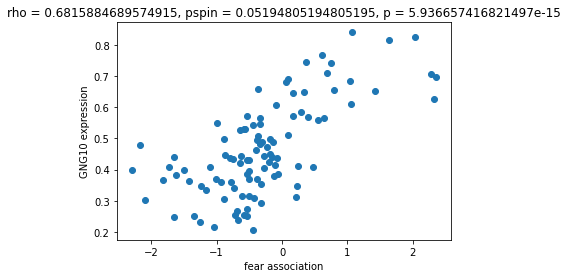

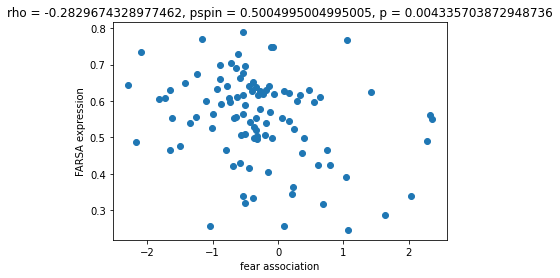

In [12]:
fig, ax1 = plt.subplots()
ax1.scatter(fear.array[:100], expression[max_gene].array[:100])
ax1.set_xlabel('fear association')
ax1.set_ylabel(max_gene + ' expression')
ax1.set_title('rho = ' + str(rho[max_idx]) + ', pspin = ' + str(pspin_gng) + ', p = ' + str(pval[max_idx]))

fig, ax2 = plt.subplots()
ax2.scatter(fear.array[:100], expression.iloc[:100, rand].array)
ax2.set_xlabel('fear association')
ax2.set_ylabel(expression.columns[rand] + ' expression')
ax2.set_title('rho = ' + str(rho[rand]) + ', pspin = ' + str(pspin_rand) + ', p = ' + str(pval[rand]))
